## CMPE 462 HOMEWORK 3

In [1]:
# Allowed Libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Multilayered Perceptron
**Target:** Implement multi-layer perceptron and analyze the results

**Data:**  The dataset (points2d.dat) is attached to the email. The sample includes 400 instances. Each instance is represented by a feature vector of 2 dimensions. The third column corresponds to the class (0/1/2) of the instance.

- Report how you split the sample for training and test. Report how you designed your neural network to solve this 3-class problem.(number of layers, error function etc.)
- Derive weight update equations using hyperbolic tangent activation function for hidden layers and sigmoid activation function for output layer . Submit a hard-copy of this derivation, drawing the the corresponding neural network with hidden units. All the formulas and the corresponding symbols should be clear. 
- Implement multi-layer perceptron with 5 hidden units. While training at each iteration, plot the error on training and test sets.
- After training converges: Plot the validation/test set and show true positives, true negatives,false positives, and false negatives (with different markers, colors, etc.)

# Report
I splitted the dataset in 3 parts for training, validation (parameter tuning), and test in method split_data().
  * I decided for values 80% for the training data, 10% for the validation data and 10% for the test data.

## Architecture
#### Layers
    
  * The input layer has 2 nodes - 1 for each feature given in the dataset.
  * The hidden layer has 5 nodes as requested.
  * The output layer has 3 nodes for 3-way classification.

### Activation Functions & Error Function
  
  * I have used sigmoid as the activation function for both layers.
  * I have first tried tanh function for activation of the hidden layer. However, it was giving 60-65 % accuracy. 
  * So I have switched to sigmoid function.
  * Error function is **Mean Square Error**
  * I have used one hot encoding to evaluate the output of the neural net.

Total: 400, Training: 320, Validation: 40, Test: 40 


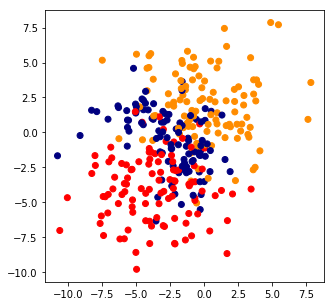

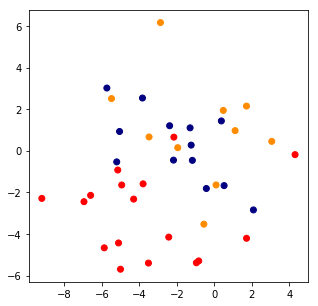

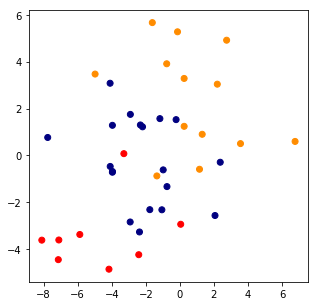

In [2]:
percentages = [80,10,10]

COLORS = ['darkorange','navy','red']
def read_data():
    data = []
    with open('points2d.dat') as fp:
        for line in fp:
            raw = line.split()
            converted = [float(raw[0]),float(raw[1]),int(raw[2])]
            data.append(converted)
    return np.array(data)

def split_data(data):
    first_seperator = (int)(percentages[0]*len(data)/100.0)
    second_seperator = (int)((percentages[0]+percentages[1])*len(data)/100.0)
    
    training_data = data[0:first_seperator]
    validation_data = data[first_seperator:second_seperator]
    test_data = data[second_seperator:]
    
    return training_data,validation_data,test_data

def plot_data(data):
    fig, axs = plt.subplots(1, figsize=(5, 5))
    axs.scatter(data[:,0], data[:,1], c=data[:,2], cmap=matplotlib.colors.ListedColormap(COLORS))
    plt.show()

data = read_data()
training, validation, test = split_data(data)

print("Total: %s, Training: %s, Validation: %s, Test: %s " %(len(data),len(training),len(validation),len(test)))

plot_data(training)
plot_data(validation)
plot_data(test)

In [3]:
class MLP:
    def __init__(self, data, validation_data, test_data, feature_count=2, hidden_count=5,output_count=3):
        self.feature_count = feature_count
        self.output_count = output_count
        self.hidden_count = hidden_count
        
        self.data,self.labels = self._split_data_labels(data)
        self.validation_data,self.validation_data_labels = self._split_data_labels(validation_data)
        self.test_data,self.test_data_labels = self._split_data_labels(test_data)
        
        self.one_hot_labels = self._convert_labels_to_one_hot_encoding(self.labels)
        self.one_hot_labels_validation = self._convert_labels_to_one_hot_encoding(self.validation_data_labels)
        self.one_hot_labels_test = self._convert_labels_to_one_hot_encoding(self.test_data_labels)
        
        self.w1 = np.random.rand(feature_count,hidden_count)
        self.b1 = np.random.randn(hidden_count)
        
        self.w2 = np.random.rand(hidden_count,output_count)
        self.b2 = np.random.randn(output_count)
        
    def _split_data_labels(self,inp):
        return inp[:,:self.feature_count],inp[:,-1]
    
    def _tanh(self,x):
        return np.tanh(x)
    
    def _tanh_derivative(self,x):
        return 1 - np.power(np.tanh(x),2)
    
    def _sigmoid(self,x):
        return 1/(1+np.exp(-x))
    
    def _sigmoid_derivative(self,x):
        return x*(1-x)
    
    def _convert_labels_to_one_hot_encoding(self,labels):
        one_hot_labels = np.eye(self.output_count)[labels.astype(int)]
        return one_hot_labels.astype(int)
    
    def _error(self,one_hot_real_labels, output):
        #return - np.sum(one_hot_real_labels * np.log(output)) / len(output)
        return np.sum((1 / 2) * (np.power((output - one_hot_real_labels), 2))) / len(output)
    
    def print_data(self):
        print("Data")
        print(self.data)
        
        print("Labels")
        print(self.labels)
    
    
    def _forward_propagation(self):
        hidden_output = self._tanh(np.dot(self.data, self.w1) + self.b1)
        output = self._softmax(np.dot(hidden_output, self.w2) + self.b2)
        
        hidden_output_test = self._tanh(np.dot(self.test_data, self.w1) + self.b1)
        output_test = self._softmax(np.dot(hidden_output_test, self.w2) + self.b2)
        
        training_error = self._error(self.one_hot_labels, output)
        test_error = self._error(self.one_hot_labels_test, output_test)
        
        return hidden_output, output, training_error, test_error
    
    def _backward_propagation(self,hidden_output,output,learning_rate):
        # Calculate deltas
        delta_w2 = (output-self.one_hot_labels) #* self._sigmoid_derivative(output)
        delta_b2 = delta_w2.sum(axis=0)
        
        delta_w1 = np.dot(delta_w2,self.w2.T) * self._tanh_derivative(hidden_output) 
        delta_b1 = delta_w1.sum(axis=0)
        
        # Learn 
        self.w2 -= learning_rate * np.dot(hidden_output.T, delta_w2)
        self.w1 -= learning_rate * np.dot(self.data.T, delta_w1)
    
        self.b2 -= learning_rate * delta_b2
        self.b1 -= learning_rate * delta_b1
        
    def train(self,epoch_count=500,learning_rate=0.5):
        self.train_errors = []
        self.test_errors = []
        
        for i in range(epoch_count):
            
            # Forward Propagation
            hidden_output = self._sigmoid(np.dot(self.data, self.w1) + self.b1)
            output = self._sigmoid(np.dot(hidden_output, self.w2) + self.b2)

            hidden_output_test = self._sigmoid(np.dot(self.test_data, self.w1) + self.b1)
            output_test = self._sigmoid(np.dot(hidden_output_test, self.w2) + self.b2)

            train_error = self._error(self.one_hot_labels, output)
            test_error = self._error(self.one_hot_labels_test, output_test)
            
            # Backpropagation 
            delta_w2 = (output-self.one_hot_labels) * self._sigmoid_derivative(output)
            delta_b2 = delta_w2.sum(axis=0)

            delta_w1 = np.dot(delta_w2,self.w2.T) * self._sigmoid_derivative(hidden_output) 
            delta_b1 = delta_w1.sum(axis=0)

            # Learn 
            self.w2 -= learning_rate * np.dot(hidden_output.T, delta_w2)
            self.w1 -= learning_rate * np.dot(self.data.T, delta_w1)

            self.b2 -= learning_rate * delta_b2
            self.b1 -= learning_rate * delta_b1
            
            # Save the errors.
            self.train_errors.append(train_error)
            self.test_errors.append(test_error)
        
        # Plot the errors.
        plt.plot(self.train_errors, label='Training Data')
        plt.plot(self.test_errors, label='Test Data')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Squared Error')
        plt.show()
            
    def predict(self,points):
        features = points[:,:self.feature_count]
        labels = points[:,-1]
        
        hidden_output = self._sigmoid(np.dot(features, self.w1) + self.b1)
        output = self._sigmoid(np.dot(hidden_output, self.w2) + self.b2)
        
        correct_count = 0
        total_count = len(points)
        
        for i,o in enumerate(output):
            predicted_class = np.argmax(o)
            correct_class = int(labels[i])
            
            if correct_class == predicted_class:
                correct_count+=1
        print("Accuracy: ", correct_count*100.0/total_count)
        return output

In [4]:
def _convert_labels_from_one_hot_encoding(one_hot_labels): #(self, one_hot_labels)
    labels = [np.argmax(a) for a in one_hot_labels]
    return labels

def plot_errors(data, output):
    fig, axs = plt.subplots(1,3,figsize=(15, 5))
    true_pos = [[[],[],[]],[[],[],[]],[[],[],[]]]
    false_neg = [[[],[],[]],[[],[],[]],[[],[],[]]]
    false_pos = [[[],[],[]],[[],[],[]],[[],[],[]]]
    output = _convert_labels_from_one_hot_encoding(output)
    for i, data_entry in enumerate(data):
        true_label = int(data_entry[2])
        if (true_label == output[i]):
            true_pos[true_label][0].append(data_entry[0])
            true_pos[true_label][1].append(data_entry[1])
            true_pos[true_label][2].append(data_entry[2])
        else:
            false_neg[true_label][0].append(data_entry[0])
            false_neg[true_label][1].append(data_entry[1])
            false_neg[true_label][2].append(data_entry[2])
    
    for i, pred_label in enumerate(output):
        data_entry = data[i]
        true_label = int(data_entry[2])
        if pred_label != true_label:
            false_pos[pred_label][0].append(data_entry[0])
            false_pos[pred_label][1].append(data_entry[1])
            false_pos[pred_label][2].append(data_entry[2])
    true_pos = np.array(true_pos)
    false_neg = np.array(false_neg)
    false_pos = np.array(false_pos)
    for label in range(3):
        if len(true_pos[label]) !=0: axs[label].scatter(true_pos[label][0], true_pos[label][1], label='True positive')
        if len(false_neg[label]) !=0: axs[label].scatter(false_neg[label][0], false_neg[label][1], marker='s', label='False negative')
        if len(false_pos[label]) !=0: axs[label].scatter(false_pos[label][0], false_pos[label][1], marker='*', label='False positive')
        title = "Class " + str(label)
        axs[label].set_title(title)
        axs[label].legend()
    plt.show()

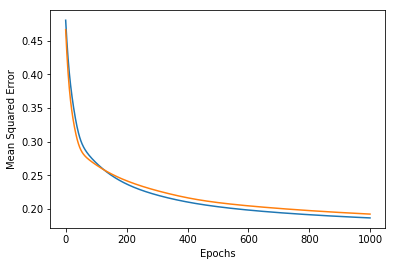

Test Data
Accuracy:  72.5


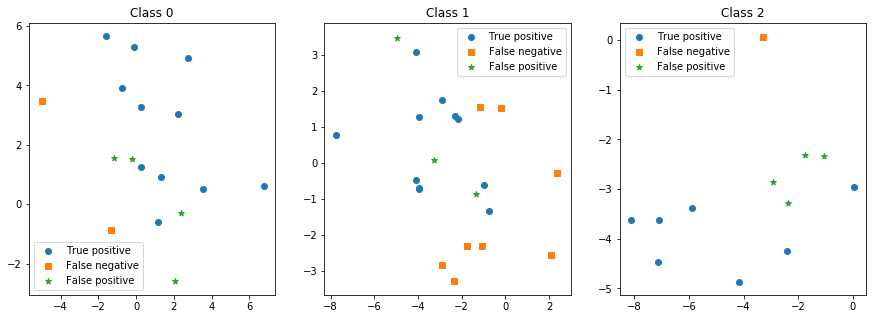

Validation Data
Accuracy:  75.0


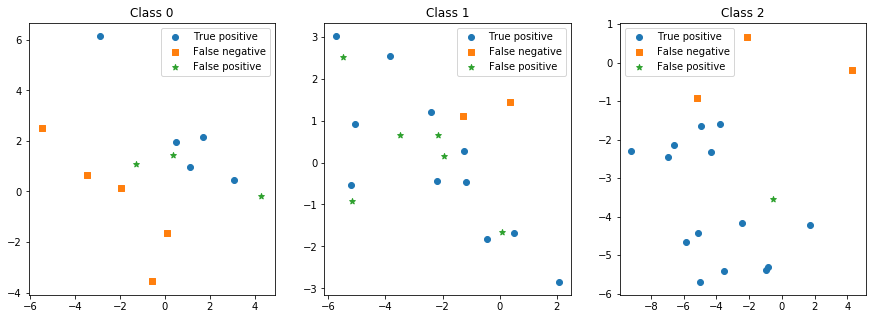

In [5]:
mlp = MLP(data,validation,test,feature_count=2,hidden_count=5,output_count=3)
mlp.train(epoch_count=1000,learning_rate=0.001)

print("Test Data")
test_output = mlp.predict(test)
plot_errors(test, test_output)

print("Validation Data")
validation_output = mlp.predict(validation)
plot_errors(validation, validation_output)